# Packages and Global Variables
Basic plot for Aburra Valley.


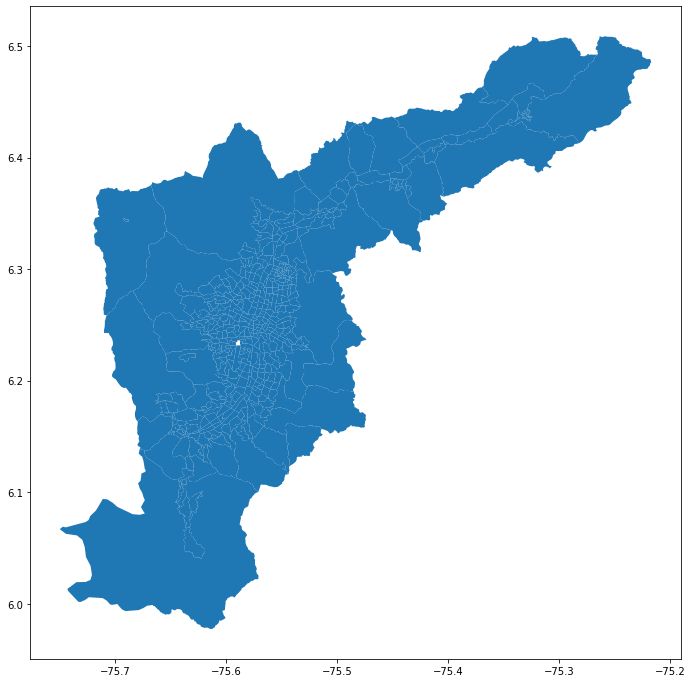

In [1]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from shapely.ops import cascaded_union
from shapely.geometry import Polygon
%matplotlib inline

aburra_valley = gp.read_file("maps/EOD.shp")

# Plotting
aburra_valley.plot(figsize=(12, 12))
plt.show()

## Reduction by Area
Here an attempt to eliminate smaller sit zones can be found.


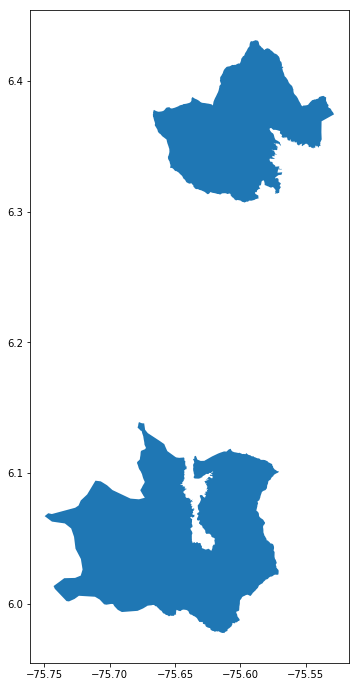

In [3]:
# Reduce small places
to_eliminate = []
area_to_eliminate = 5.5e-3
for index, row in aburra_valley.iterrows():
    if row['geometry'].area < area_to_eliminate:
        to_eliminate.append(index)

aburra_less = aburra_valley.drop(to_eliminate, axis=0)
aburra_less.plot(figsize=(12, 12))
plt.show()

## Polygon of Border


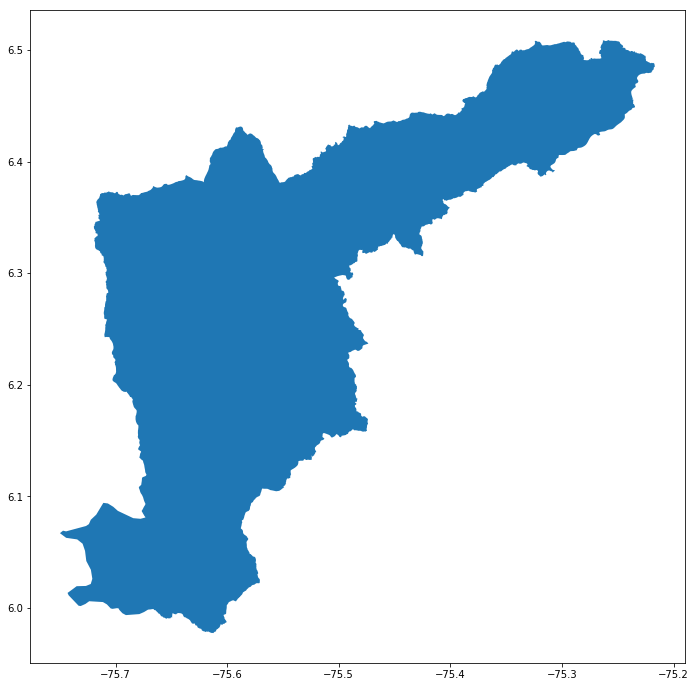

In [9]:
# Create aburra merged
aburra_merged = aburra_valley.unary_union

# Merging
aburra_valley_polygon = aburra_merged
x, y = aburra_valley_polygon.exterior.coords.xy
coord = np.dstack((x, y)).tolist()

plotting = False
if plotting:
    for i in range(len(coord[0]) - 1):
        plt.plot((coord[0][i][0], coord[0][i + 1][0]), (coord[0][i][1], coord[0][i + 1][1]), 'k')

    plt.show()

border_valley = gp.GeoSeries(Polygon(coord[0]))
border_valley.plot(figsize=(12, 12))
plt.show()

border_valley.to_file("maps/EOD_border.shp", driver="ESRI Shapefile")


## Neighbor Addition to DF


In [2]:
aburra_valley["neighbors"] = None  # add NEIGHBORS colum}
for index, zone in aburra_valley.iterrows():
    # get 'not disjoint' countries
    neighbors = aburra_valley[~aburra_valley.geometry.disjoint(zone.geometry)].SIT_2017.tolist()

    # remove own name from the list
    neighbors = [ name for name in neighbors if zone.SIT_2017 != name ]

    # add names of neighbors as NEIGHBORS value
    aburra_valley.at[index, "neighbors"] = ", ".join(neighbors)


## EOD Correction


In [115]:
aburra_valley_sorted = aburra_valley.copy()
aburra_valley_sorted["SIT_2017"] = aburra_valley_sorted["SIT_2017"].astype(int)
aburra_valley_sorted = aburra_valley_sorted.sort_values("SIT_2017")

# EOD
eod = pd.read_csv("eod_2017.csv", sep=";").dropna(axis=1)
origin_names = eod.columns[0]
eod[origin_names] = eod[origin_names].astype(int)

# Add new rows
for origin in aburra_valley_sorted["SIT_2017"]:
    if eod[origin_names].isin([origin]).any():
        continue

    index_origin = (aburra_valley_sorted["SIT_2017"] == origin).argmax()
    neighbors = list(map(int, aburra_valley_sorted["neighbors"][index_origin].split(",")))
    for neighbor in neighbors:
        if eod[origin_names].isin([neighbor]).any():
            eod_index_neighbor = (eod[origin_names] == neighbor).argmax()
            row = eod.iloc[eod_index_neighbor].copy()

            row[0] = origin
            eod = eod.append(row)
            eod = eod.sort_values(origin_names)
            break


In [119]:
failed = False
for origin in aburra_valley_sorted["SIT_2017"]:
    if not eod[origin_names].isin([origin]).any():
        print(origin)
        failed = True
        break

if failed:
    print("EOD is still ill-posed.")
else:
    print("Yay!")
    eod_print = eod.rename(columns={origin_names: ""})
    eod_print.to_csv("geod.csv", index=False)


Yay!


## Custom Format
This was done in order to facilitate the Repast HPC constuction of geography.


In [19]:
file = open("eod.map", "w")
file.write(str(aburra_merged.wkt) + "\n")
for index, zone in aburra_valley.iterrows():
    file.write(str(zone.geometry.wkt) + " | ")
    file.write(str(zone.SIT_2017) + " | ")
    file.write(zone.neighbors + "\n")